# BinaryからHF帯アンテナデータをプロット

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
from scipy.ndimage import median_filter
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import MultipleLocator, LogLocator, FuncFormatter

# 複数ファイルのパス
file_paths = [
    "/home/kinno-7010/Research/HF_plot/HF_data/20220613032000.10min",
    "/home/kinno-7010/Research/HF_plot/HF_data/20220613033000.10min",
    "/home/kinno-7010/Research/HF_plot/HF_data/20220613034000.10min",
    "/home/kinno-7010/Research/HF_plot/HF_data/20220613035000.10min",
]

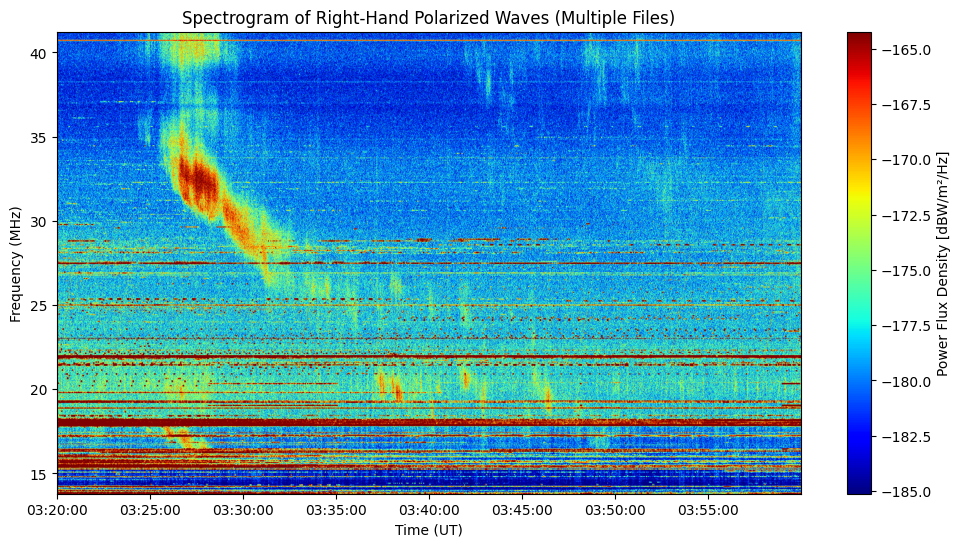

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt

# 複数ファイルのパス
file_paths = [
    "/home/kinno-7010/Research/HF_plot/HF_data/20220613032000.10min",
    "/home/kinno-7010/Research/HF_plot/HF_data/20220613033000.10min",
    "/home/kinno-7010/Research/HF_plot/HF_data/20220613034000.10min",
    "/home/kinno-7010/Research/HF_plot/HF_data/20220613035000.10min",
]

# データ格納用リスト
time_axis_all = []
power_flux_density_all = []

# データを順番に処理
for i, file_path in enumerate(file_paths):
    # バイナリデータを読み込み（16ビット符号なし整数）
    raw_data = np.fromfile(file_path, dtype=np.uint16)
    
    # 右旋偏波（RH）のデータのみを抽出（偶数番目が右旋偏波、奇数番目が左旋偏波）
    rh_data = raw_data[0::2]  # 偶数インデックスのみ取得
    
    # データの再整形 (時間600秒 × 周波数900ステップ)
    rh_data = rh_data.reshape((1200, 900))  # 1200 = 600秒 × 2（0.5秒間隔のため）
    
    # 各ファイルの開始時間
    start_time = dt.datetime(2022, 6, 13, 3, 20, 0) + dt.timedelta(minutes=10 * i)
    time_axis = [start_time + dt.timedelta(seconds=j * 0.5) for j in range(1200)]
    
    # 周波数軸の生成（公式に基づく）
    freq_steps = np.arange(900)
    frequency_axis = (452 + freq_steps) / 4096.0 * 125  # [MHz]
    
    # 強度データの変換（公式に基づく）
    freq_matrix = np.tile(frequency_axis, (1200, 1))  # 周波数ごとに計算
    power_flux_density = rh_data / 100.0 + 20 * np.log10(freq_matrix) - 270
    
    # 全データを結合
    time_axis_all.extend(time_axis)
    power_flux_density_all.append(power_flux_density)

# 連結
power_flux_density_all = np.vstack(power_flux_density_all)

# プロット
fig, ax = plt.subplots(figsize=(12, 6))

# カラープロットの設定
vmin, vmax = np.percentile(power_flux_density_all, 5), np.percentile(power_flux_density_all, 95)
img = ax.imshow(power_flux_density_all.T, aspect='auto', origin='lower',
                extent=[mdates.date2num(time_axis_all[0]), mdates.date2num(time_axis_all[-1]), 
                        frequency_axis[0], frequency_axis[-1]],
                vmin=vmin, vmax=vmax, cmap='jet')

# 軸ラベルとフォーマット
ax.set_xlabel("Time (UT)")
ax.set_ylabel("Frequency (MHz)")
ax.set_title("Spectrogram of Right-Hand Polarized Waves (Multiple Files)")

# 時間軸のフォーマット設定
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=5))  # 2分ごとに目盛り

# カラーバーの追加
cbar = plt.colorbar(img, ax=ax)
cbar.set_label("Power Flux Density [dBW/m²/Hz]")

plt.show()


In [86]:




def plot_dynamic_spectrum(start_time, end_time, title, time_interval, frequency_interval, window_frequency_size):


    # データ格納用リスト
    time_axis_all = []
    power_flux_density_all = []

    # 周波数範囲の取得
    min_frequency = float(input("min_frequency [MHz] = ")) * 1e6
    max_frequency = float(input("MAX_frequency [MHz] = ")) * 1e6
    
    for i, file_path in enumerate(file_paths):
        # バイナリデータを読み込み（16ビット符号なし整数）
        raw_data = np.fromfile(file_path, dtype=np.uint16)
        
        # 右旋偏波（RH）のデータのみを抽出
        rh_data = raw_data[0::2]
        
        # データの再整形 (時間600秒 × 周波数900ステップ)
        rh_data = rh_data.reshape((1200, 900))
        
        # 各ファイルの開始時間
        file_start_time = dt.datetime(2022, 6, 13, 3, 20, 0) + dt.timedelta(minutes=10 * i)
        time_axis = [file_start_time + dt.timedelta(seconds=j * 0.5) for j in range(1200)]
        
        # 周波数軸の生成（公式に基づく）
        freq_steps = np.arange(900)
        frequency_axis = (452 + freq_steps) / 4096.0 * 125  # [MHz]
        
        # 強度データの変換（公式に基づく）
        freq_matrix = np.tile(frequency_axis, (1200, 1))
        power_flux_density = rh_data / 100.0 + 20 * np.log10(freq_matrix) - 270
        
        # 時間と周波数のフィルタリング
        time_mask = [(t >= start_time) and (t <= end_time) for t in time_axis]
        freq_mask = (frequency_axis >= min_frequency) & (frequency_axis <= max_frequency)
        
        filtered_time_axis = [t for t, mask in zip(time_axis, time_mask) if mask]
        filtered_power_flux_density = power_flux_density[time_mask][:, freq_mask]
        frequency_sliced_mhz = frequency_axis[freq_mask]
        
        # 移動中央値フィルタの適用
        filtered_power_flux_density = median_filter(filtered_power_flux_density, size=(1, window_frequency_size))
        
        # 全データを結合
        time_axis_all.extend(filtered_time_axis)
        power_flux_density_all.append(filtered_power_flux_density)
    
    # 連結
    power_flux_density_all = np.vstack(power_flux_density_all)
    
    # プロット
    fig, ax = plt.subplots(figsize=(12, 6))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="1%", pad=0.1)
    
    vmin, vmax = np.percentile(power_flux_density_all, 10), np.percentile(power_flux_density_all, 90)
    
    img = ax.imshow(power_flux_density_all.T, aspect='auto', origin='lower',
                    extent=[mdates.date2num(time_axis_all[0]), mdates.date2num(time_axis_all[-1]), 
                            frequency_sliced_mhz[0], frequency_sliced_mhz[-1]],
                    vmin=vmin, vmax=vmax, cmap='jet')
    
    cbar = plt.colorbar(img, cax=cax)
    cbar.set_label(r'Power Flux Density (dBW/$\rm{m^2}$/Hz)', fontsize=20)
    cbar.ax.tick_params(labelsize=18)
    
    ax.set_xlabel('Time (UT)', fontsize=24)
    ax.set_ylabel('Frequency (MHz)', fontsize=24)
    ax.tick_params(axis='both', labelsize=18)
    ax.set_title(title, fontsize=20)
    ax.set_yscale('log')
    ax.yaxis.set_major_locator(LogLocator(base=10.0, subs='auto'))
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x):d}" if x >= 10 else ""))
    
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    ax.set_xlim(mdates.date2num(start_time), mdates.date2num(end_time))
    ax.xaxis.set_major_locator(mdates.SecondLocator(interval=time_interval))
    y_major_locator = MultipleLocator(frequency_interval)
    ax.yaxis.set_major_locator(y_major_locator)
    
    plt.tight_layout()
    plt.show()

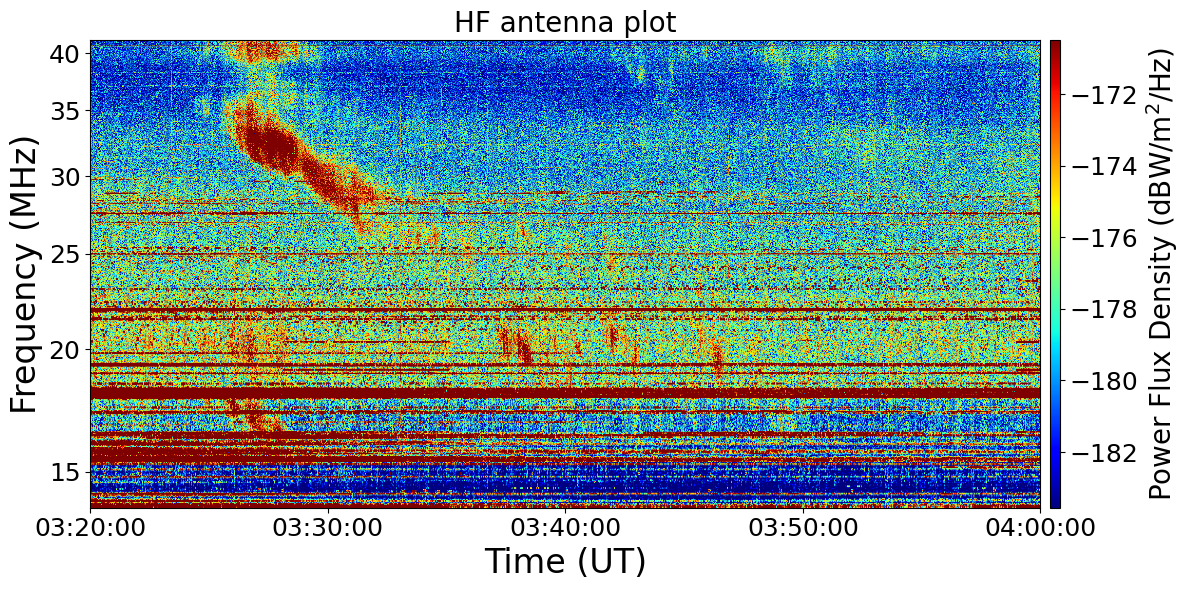

In [87]:
plot_dynamic_spectrum(start_time=np.datetime64('2022-06-13T03:20:00'),
                               end_time=np.datetime64('2022-06-13T04:00:00'),
                               title='HF antenna plot',
                               time_interval=10*60,
                               frequency_interval=5,
                               window_frequency_size=1
                               )

In [8]:
def plot_power_pass_dynamic_spectrum(start_time, end_time, percent_of_max, time_interval, frequency_interval, window_frequency_size):


    # データ格納用リスト
    time_axis_all = []
    power_flux_density_all = []

    # 周波数範囲の取得
    min_frequency = float(input("min_frequency [MHz] = ")) * 1e6
    max_frequency = float(input("MAX_frequency [MHz] = ")) * 1e6
    
    for i, file_path in enumerate(file_paths):
        # バイナリデータを読み込み（16ビット符号なし整数）
        raw_data = np.fromfile(file_path, dtype=np.uint16)
        
        # 右旋偏波（RH）のデータのみを抽出
        rh_data = raw_data[0::2]
        
        # データの再整形 (時間600秒 × 周波数900ステップ)
        rh_data = rh_data.reshape((1200, 900))
        
        # 各ファイルの開始時間
        file_start_time = dt.datetime(2022, 6, 13, 3, 20, 0) + dt.timedelta(minutes=10 * i)
        time_axis = [file_start_time + dt.timedelta(seconds=j * 0.5) for j in range(1200)]
        
        # 周波数軸の生成（公式に基づく）
        freq_steps = np.arange(900)
        frequency_axis = (452 + freq_steps) / 4096.0 * 125  # [MHz]
        
        # 強度データの変換（公式に基づく）
        freq_matrix = np.tile(frequency_axis, (1200, 1))
        power_flux_density = rh_data / 100.0 + 20 * np.log10(freq_matrix) - 270
        
        # 時間と周波数のフィルタリング
        time_mask = [(t >= start_time) and (t <= end_time) for t in time_axis]
        freq_mask = (frequency_axis >= min_frequency) & (frequency_axis <= max_frequency)
        
        filtered_time_axis = [t for t, mask in zip(time_axis, time_mask) if mask]
        filtered_power_flux_density = power_flux_density[time_mask][:, freq_mask]
        frequency_sliced_mhz = frequency_axis[freq_mask]
        
        # 移動中央値フィルタの適用
        filtered_power_flux_density = median_filter(filtered_power_flux_density, size=(1, window_frequency_size))
        
        # 全データを結合
        time_axis_all.extend(filtered_time_axis)
        power_flux_density_all.append(filtered_power_flux_density)
    
    # 連結
    power_flux_density_all = np.vstack(power_flux_density_all)
    
    power_pass = np.min(power_flux_density_all)*(1-percent_of_max*0.01)
    
    power_flux_density_all_power_pass = np.where(power_pass <= power_flux_density_all, power_flux_density_all, np.nan) # & np.where(lh_data_sliced <= threshold_noise_min, lh_data_sliced, np.nan)
    print('power_flux_density_all:', power_flux_density_all)
    print('mean:', np.mean(power_flux_density_all))
    print('power_pass:', power_pass)
    
    pfd_min = np.min(power_flux_density_all)
    pfd_max = np.max(power_flux_density_all)
    pfd_mean = np.mean(power_flux_density_all)
    print(f"Power Flux Density Range: Min={pfd_min}, Max={pfd_max}, Mean={pfd_mean}")

    
    # プロット
    fig, ax = plt.subplots(figsize=(12, 6))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="1%", pad=0.1)
    
    vmin, vmax = np.percentile(power_flux_density_all, 5), np.percentile(power_flux_density_all, 95)
    
    img = ax.imshow(power_flux_density_all_power_pass.T, aspect='auto', origin='lower',
                    extent=[mdates.date2num(time_axis_all[0]), mdates.date2num(time_axis_all[-1]), 
                            frequency_sliced_mhz[0], frequency_sliced_mhz[-1]],
                    vmin=vmin, vmax=vmax, cmap='jet')
    
    cbar = plt.colorbar(img, cax=cax)
    cbar.set_label(r'Power Flux Density (dBW/$\rm{m^2}$/Hz)', fontsize=18)
    cbar.ax.tick_params(labelsize=18)
    
    ax.set_xlabel('Time (UT)', fontsize=24)
    ax.set_ylabel('Frequency (MHz)', fontsize=24)
    ax.tick_params(axis='both', labelsize=18)
    ax.set_title(r'HF antenna plot (Power$\geq P_{\mathrm{max}}\times$'+f'{percent_of_max}%)', fontsize=20)
    ax.set_yscale('log')
    ax.yaxis.set_major_locator(LogLocator(base=10.0, subs='auto'))
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x):d}" if x >= 10 else ""))
    
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    ax.set_xlim(mdates.date2num(start_time), mdates.date2num(end_time))
    ax.xaxis.set_major_locator(mdates.SecondLocator(interval=time_interval))
    y_major_locator = MultipleLocator(frequency_interval)
    ax.yaxis.set_major_locator(y_major_locator)
    
    plt.tight_layout()
    plt.show()

power_flux_density_all: [[-144.37623    -138.58703466 -142.90788164 ... -181.41875971
  -180.23232333 -187.28589172]
 [-146.95623    -141.14703466 -148.93788164 ... -182.18875971
  -181.69232333 -185.56589172]
 [-144.51623    -138.38703466 -146.05788164 ... -185.10875971
  -182.83232333 -178.66589172]
 ...
 [-165.10623    -160.59703466 -167.14788164 ... -176.69875971
  -177.41232333 -182.79589172]
 [-164.97623    -160.92703466 -166.45788164 ... -177.16875971
  -177.20232333 -177.31589172]
 [-163.66623    -160.25703466 -167.38788164 ... -180.51875971
  -178.95232333 -180.42589172]]
mean: -177.4364163580052
power_pass: -205.67554184489268
Power Flux Density Range: Min=-205.67554184489268, Max=-124.14414851040786, Mean=-177.4364163580052


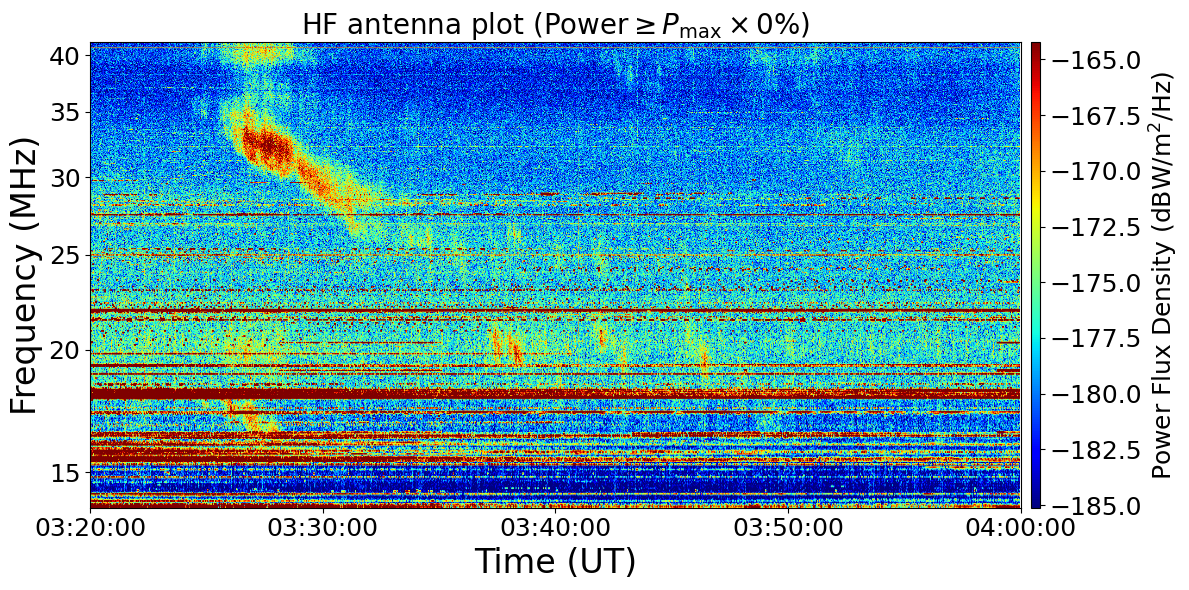

In [9]:
plot_power_pass_dynamic_spectrum(start_time=np.datetime64('2022-06-13T03:20:00'),
                               end_time=np.datetime64('2022-06-13T04:00:00'),
                               percent_of_max=0,
                               time_interval=10*60,
                               frequency_interval=5,
                               window_frequency_size=1
                               )